In [1]:
%config Completer.use_jedi = False

Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.datasets import load_digits

In [4]:
X, y = load_digits(as_frame=False, return_X_y=True)

In [5]:
print(f'X shape is {X.shape}; y shape is {y.shape}.')

X shape is (1797, 64); y shape is (1797,).


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

In [6]:
# convert color palette for X
X = np.absolute(np.subtract(X, 16))

In [7]:
# make viz in black-white palette
plt.gray()

<Figure size 432x288 with 0 Axes>

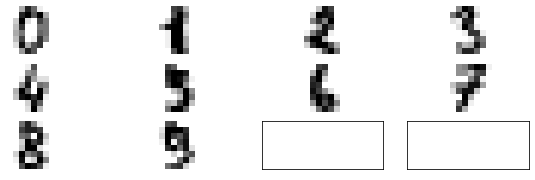

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
for ax, image in zip(axes.flatten(), X[:10]):
    image = image.reshape((8,8))
    ax.set_axis_off()
    ax.imshow(image, interpolation=None)

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [9]:
# import necessary libs
from sklearn.cluster import AgglomerativeClustering, KMeans

In [10]:
# initiate algorithms
aglmc = AgglomerativeClustering(n_clusters=10)
kmeans = KMeans(n_clusters=10, n_init=100)

In [11]:
# make clusters
aglmc_result = aglmc.fit_predict(X)
kmeans_result = kmeans.fit_predict(X)
print(f'AgglomerativeClustering result is {np.unique(aglmc_result)}, KMeans result is {np.unique(kmeans_result)}.')

AgglomerativeClustering result is [0 1 2 3 4 5 6 7 8 9], KMeans result is [0 1 2 3 4 5 6 7 8 9].


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

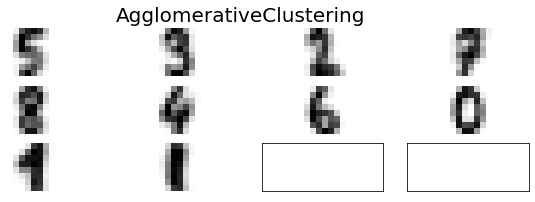

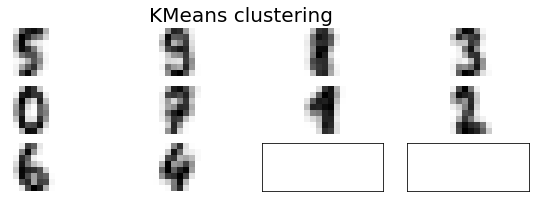

In [12]:
names = {'AgglomerativeClustering' : aglmc_result ,
         'KMeans clustering' : kmeans_result}

for name, result in names.items():
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
    fig.suptitle(f'{name}', fontsize=20)
    
    for ax, i in zip(axes.flatten(), range(10)):
        image = np.mean(X[result==i], axis=0).reshape((8,8))
        ax.set_axis_off()
        ax.imshow(image, interpolation=None)

#### Вывод
Визульно не получается дать однозначный ответ, какой из методов дал лучший результат, так как определенные цифры для одного метода получились лучше чем для другого, и наоборот. Попробую предположить, что лучше все-таки справился `KMeans`.

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [13]:
from sklearn.metrics import silhouette_score

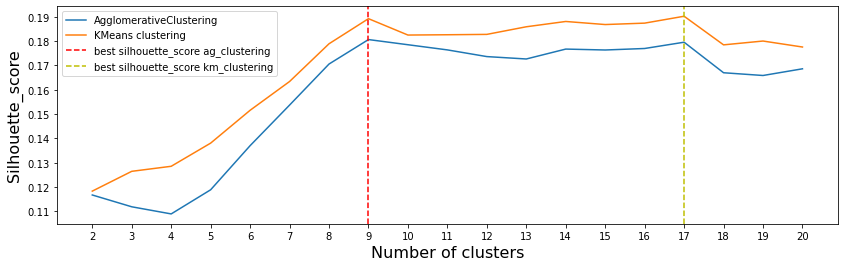

In [14]:
ag_clustering_s, km_clustering_s = [], []
k_range = [x for x in range(2,21)]

for K in k_range:
    aglmc = AgglomerativeClustering(n_clusters=K)
    res_ag = aglmc.fit_predict(X)
    ag_clustering_s.append(silhouette_score(X, res_ag))
    
    kmeans = KMeans(n_clusters=K, n_init=100)
    res_km = kmeans.fit_predict(X)
    km_clustering_s.append(silhouette_score(X, res_km))

plt.figure(figsize=(14,4))
plt.plot(k_range, ag_clustering_s, label='AgglomerativeClustering')
plt.plot(k_range, km_clustering_s, label='KMeans clustering')
plt.axvline(np.argmax(ag_clustering_s)+2, label='best silhouette_score ag_clustering', color='r', linestyle='dashed')
plt.axvline(np.argmax(km_clustering_s)+2, label='best silhouette_score km_clustering', color='y', linestyle='dashed')
plt.legend(loc='best')
plt.xticks(k_range)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Silhouette_score', fontsize=16);

##### Вывод
Как видно из графика, лучшее значение силуэта для двух алгоритмов достигается при разном количестве кластеров, для Иерархического алгоритма это 9 кластеров, а для К-средних это 17 кластеров. Однако если применить метод локтя, то оптимальное количество кластеров для двух алгоритмов будет одинаково.<br><br>
P.S. При перезапуске ноутбука может измениться количество кластеров

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [15]:
from sklearn.metrics import v_measure_score

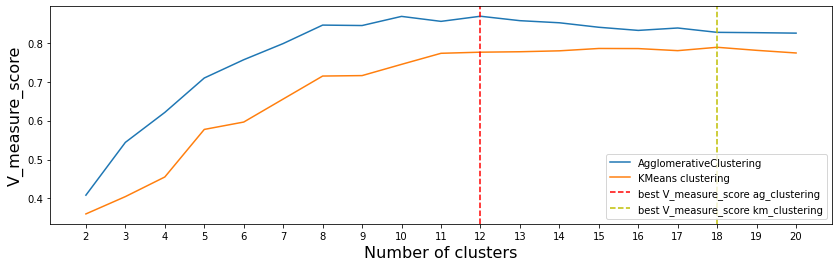

In [16]:
ag_clustering_v, km_clustering_v = [], []
k_range = [x for x in range(2,21)]

for K in k_range:
    aglmc = AgglomerativeClustering(n_clusters=K)
    res_ag = aglmc.fit_predict(X)
    ag_clustering_v.append(v_measure_score(y, res_ag))
    
    kmeans = KMeans(n_clusters=K, n_init=100)
    res_km = kmeans.fit_predict(X)
    km_clustering_v.append(v_measure_score(y, res_km))

plt.figure(figsize=(14,4))
plt.plot(k_range, ag_clustering_v, label='AgglomerativeClustering')
plt.plot(k_range, km_clustering_v, label='KMeans clustering')
plt.axvline(np.argmax(ag_clustering_v)+2, label='best V_measure_score ag_clustering', color='r', linestyle='dashed')
plt.axvline(np.argmax(km_clustering_v)+2, label='best V_measure_score km_clustering', color='y', linestyle='dashed')
plt.legend(loc='best')
plt.xticks(k_range)
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('V_measure_score', fontsize=16);

##### Вывод
Как видно из графика, лучшее значение $V$ - меры для двух алгоритмов достигается при разном количестве кластеров, для Иерархического алгоритма это 12 кластеров, а для К-средних это 18 кластеров.<br><br>
P.S. При перезапуске ноутбука может измениться количество кластеров

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [17]:
from sklearn.decomposition import TruncatedSVD

In [18]:
# initiate algorithms
aglmc = AgglomerativeClustering(n_clusters=10)
kmeans = KMeans(n_clusters=10, n_init=100)
# set number of components
number_of_components = [2, 5, 10, 20]
ag_tsvd_res_sil, km_tsvd_res_sil, ag_tsvd_res_v, km_tsvd_res_v = [], [], [], []

for n in number_of_components:
    tsvd = TruncatedSVD(n_components=n)
    X_tsvd = tsvd.fit_transform(X)
    ag_res_y = aglmc.fit_predict(X_tsvd)
    km_res_y = kmeans.fit_predict(X_tsvd)
    
    ag_tsvd_res_sil.append(silhouette_score(X_tsvd, ag_res_y))
    km_tsvd_res_sil.append(silhouette_score(X_tsvd, km_res_y))
    ag_tsvd_res_v.append(v_measure_score(y, ag_res_y))
    km_tsvd_res_v.append(v_measure_score(y, km_res_y))

##### Нарисуем результаты для более наглядного анализа
Используем bar chart для визуализации. Будем сравнивать максимальные значения силуэта и $V$-меры для двух алгоритмов, полученных на исходных данных и данных с уменьшенной размерностью

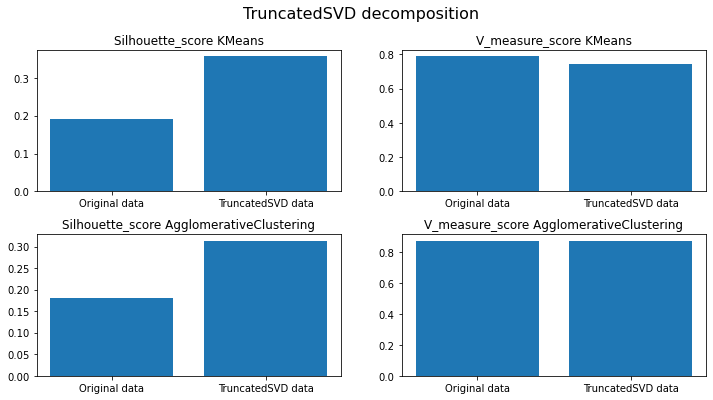

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
fig.suptitle('TruncatedSVD decomposition', fontsize=16)
x_ticks = ['Original data', 'TruncatedSVD data']
axes[0][0].bar(x_ticks, [max(km_clustering_s), max(km_tsvd_res_sil)])
axes[0][0].set_title('Silhouette_score KMeans')

axes[0][1].bar(x_ticks, [max(km_clustering_v), max(km_tsvd_res_v)])
axes[0][1].set_title('V_measure_score KMeans');

axes[1][0].bar(x_ticks, [max(ag_clustering_s), max(ag_tsvd_res_sil)])
axes[1][0].set_title('Silhouette_score AgglomerativeClustering')

axes[1][1].bar(x_ticks, [max(ag_clustering_v), max(ag_tsvd_res_v)])
axes[1][1].set_title('V_measure_score AgglomerativeClustering');

plt.subplots_adjust(hspace=0.3)

##### Выводы
Наиболее разительные изменения получил "силуэт", он вырос для двух алгоритмов при уменьшение размерности исходных данных. Также можно заметить что и $V$-мера также изменилась, но не так явно. Для алгоритма К-средних она даже снизилась, а для Иерархического незначительно выросла.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

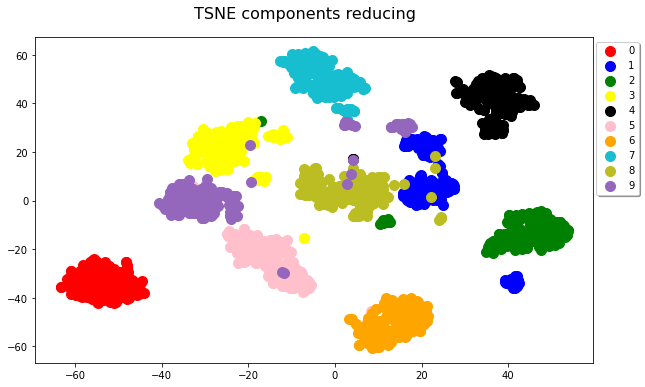

In [22]:
scatter_x = X_tsne[:, 0]
scatter_y = X_tsne[:, 1]
cdict = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'black', 5: 'pink', 6: 'orange', 7: 'tab:cyan', 8: 'tab:olive',\
         9: 'tab:purple'}

fig, axes = plt.subplots(figsize=(10,6))
fig.suptitle('TSNE components reducing', fontsize=16, y=0.95)
for g in np.unique(y):
    ix = np.where(y == g)
    axes.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = g, s = 100)
axes.legend(bbox_to_anchor=(1.09, 1.), fancybox=True, shadow=True);

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [23]:
# perfom algorithms on X_tsne
aglmc_tsne = aglmc.fit_predict(X_tsne)
kmeans_tsne = kmeans.fit_predict(X_tsne)
# calculate silhouette_score and V_measure for both algorithms
# AgglomerativeClustering
aglmc_tsne_sil = silhouette_score(X_tsne, aglmc_tsne)
aglmc_tsne_v = v_measure_score(y, aglmc_tsne)
# KMeans clustering
kmeans_tsne_sil = silhouette_score(X_tsne, kmeans_tsne)
kmeans_tsne_v = v_measure_score(y, kmeans_tsne)

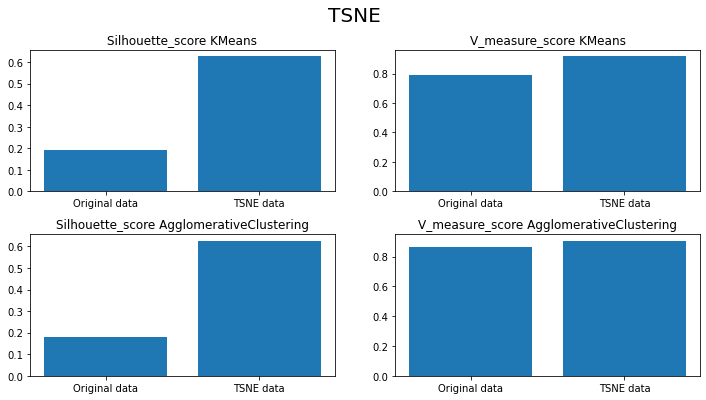

In [24]:
# plot the results
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
fig.suptitle('TSNE', fontsize=20)
x_ticks = ['Original data', 'TSNE data']
axes[0][0].bar(x_ticks, [max(km_clustering_s), kmeans_tsne_sil])
axes[0][0].set_title('Silhouette_score KMeans')

axes[0][1].bar(x_ticks, [max(km_clustering_v), kmeans_tsne_v])
axes[0][1].set_title('V_measure_score KMeans');

axes[1][0].bar(x_ticks, [max(ag_clustering_s), aglmc_tsne_sil])
axes[1][0].set_title('Silhouette_score AgglomerativeClustering')

axes[1][1].bar(x_ticks, [max(ag_clustering_v), aglmc_tsne_v])
axes[1][1].set_title('V_measure_score AgglomerativeClustering');

plt.subplots_adjust(hspace=0.3)

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

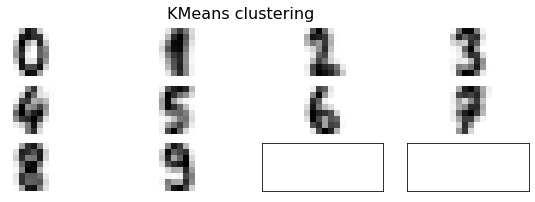

In [25]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('KMeans clustering', fontsize=16)
res_dict =  dict(zip(y, kmeans_tsne))
    
for ax, i in zip(axes.flatten(), res_dict.values()):
    image = np.mean(X[kmeans_tsne==i], axis=0).reshape((8,8))
    ax.set_axis_off()
    ax.imshow(image, interpolation=None)

##### Добавим немного магии (интерполяции)

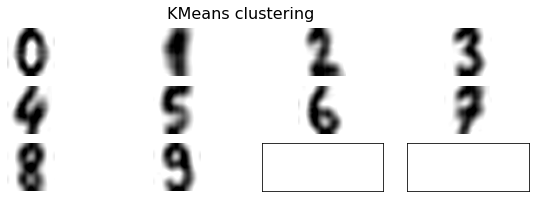

In [26]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('KMeans clustering', fontsize=16)
res_dict =  dict(zip(y, kmeans_tsne))
    
for ax, i in zip(axes.flatten(), res_dict.values()):
    image = np.mean(X[kmeans_tsne==i], axis=0).reshape((8,8))
    ax.set_axis_off()
    ax.imshow(image, interpolation='sinc')

WOW

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

#### Вывод
В ходе данной работы мы использовали 2 вида кластеризации, К-средних и Иерархическую. Если рассматривать то, насколько хорошо они определяли количество кластеров в датасете (нам известно что их 10), то более высокие показатели Силуэта и $V$-меры были у Иерархического вида кластеризации, и эти результаты достигались при количестве кластеров, близким к количество исходных кластеров (9 и 12 соответственно).<br><br>
В данной работе мы не настраивали параметры алгоритмов, а только меняли входные данные, но это очевидно, что подбор правильных гиперпараметров для алгоритма улучшит его результат работы. <br><br>
Хоть визуально это не особо заметно(или у меня уже замылены глаза), однако судя по метрикам Силуэта и $V$-меры кластеризация улучшилась, когда мы даем алгоритму на входе данные меньше размерности, особенно это было заметно при использовании метода tSNE.<br><br>
P.S. Интерполяция творит чудеса

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [27]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

##### Последовательность действий
Как и было сказано в лекции, просто так кластеризовать данный датасет не получится, так как нам не хватает памяти. Однако есть уже готовое рещение как это сделать, это метод К-средних для больших датасетов `MiniBatchKMeans`. В данной работе мы подсчитаем скор силуэта и $V$-меры на оригинальных данных, а затем снизим размерность что бы добиться лучших значений наших метрик.

In [28]:
# import the algorithm
from sklearn.cluster import MiniBatchKMeans

In [29]:
# exchange white-black images to black-white
X_new = np.absolute(np.subtract(X, 255))

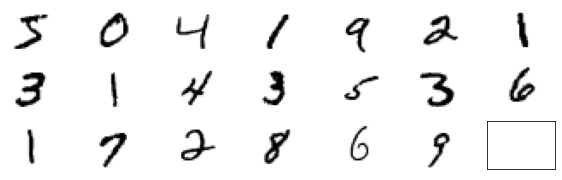

In [30]:
# lets plot first 20 images from dataset
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
for ax, image in zip(axes.flatten(), X_new[:20]):
    image = image.reshape((28,28))
    ax.set_axis_off()
    ax.imshow(image, interpolation=None)

In [54]:
# let's figure out how many clusters do we need
num_of_clusters = len(np.unique(y))
num_of_clusters

10

##### Определим алгоритм для дальнейшей работы

In [31]:
mb_kmeans = MiniBatchKMeans(n_clusters=num_of_clusters, n_init=100, batch_size=2048)

##### Выбор количества компонентов для снижения размерности `TruncatedSVD`
Попробуем выбрать количество компонентов при котором достигается лучшее значение силуэта и в-меры

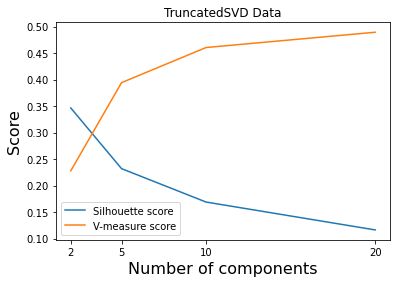

In [46]:
# set number of components
number_of_components = [2, 5, 10, 20]
km_tsvd_res_sil, km_tsvd_res_v = [], []

for n in number_of_components:
    tsvd = TruncatedSVD(n_components=n)
    X_tsvd = tsvd.fit_transform(X_new)
    km_res_y = mb_kmeans.fit_predict(X_tsvd)
    
    km_tsvd_res_sil.append(silhouette_score(X_tsvd, km_res_y))
    km_tsvd_res_v.append(v_measure_score(y, km_res_y))
    
plt.plot(number_of_components, km_tsvd_res_sil, label='Silhouette score')
plt.plot(number_of_components, km_tsvd_res_v, label='V-measure score')
plt.legend(loc='best')
plt.xticks(number_of_components)
plt.xlabel('Number of components', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.title('TruncatedSVD Data');

При количестве компонентов равном 2 мы получем лучшее значение в-меры, однако худшее значение силуэта. Попробуем для разного количества компонентов. Выберем для дальнейшего анализа количество компонентов равным 5

##### Проанализируем результаты скоров для кластеризации при разных типах входных данных

In [57]:
# TruncatedSVD for number of components = 5
tsvd = TruncatedSVD(n_components=5)
X_new_tsvd5 = tsvd.fit_transform(X_new)

# tSNE for number of components = 2
tsne = TSNE(n_components=2)
X_new_tsne2 = tsne.fit_transform(X_new)

Прокластеризируем данные

In [58]:
y_mb_kmeans_res_origin = mb_kmeans.fit_predict(X_new)
y_mb_kmeans_res_trunc5 = mb_kmeans.fit_predict(X_new_tsvd5)
y_mb_kmeans_res_tsne = mb_kmeans.fit_predict(X_new_tsne2)

Подсчитаем метрики

In [59]:
bonus_dict = {
    'origin_data' : [X_new, y_mb_kmeans_res_origin],
    'Truncated_data' : [X_new_tsvd5, y_mb_kmeans_res_trunc5],
    'TSNE_data' : [X_new_tsne2, y_mb_kmeans_res_tsne]
}

sil_score_bonus, v_measure_score_bonus = [], []
for k, v in bonus_dict.items():
    sil_score_bonus.append(silhouette_score(v[0], v[1]))
    v_measure_score_bonus.append(v_measure_score(y, v[1]))

Представим результаты графически

Text(0.5, 1.0, 'V-measure score')

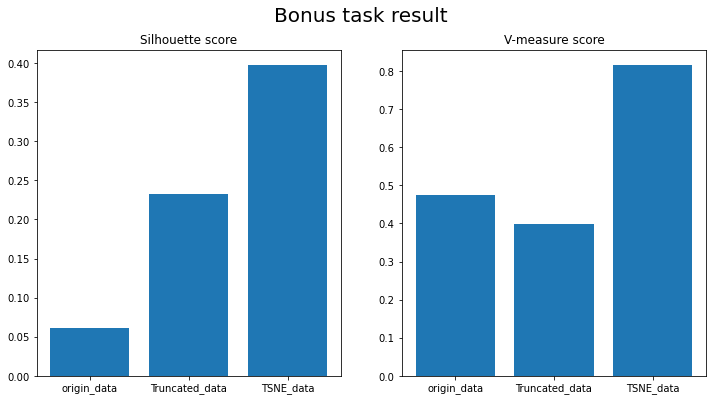

In [61]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
fig.suptitle('Bonus task result', fontsize=20)

axes[0].bar(x=list(bonus_dict.keys()), height=sil_score_bonus)
axes[0].set_title('Silhouette score')

axes[1].bar(x=list(bonus_dict.keys()), height=v_measure_score_bonus)
axes[1].set_title('V-measure score')

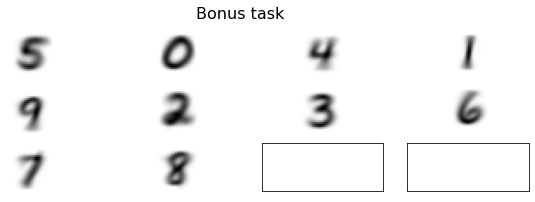

In [64]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10,3), subplot_kw={'xticks': [], 'yticks': []})
fig.suptitle('Bonus task', fontsize=16)
res_dict =  dict(zip(y, y_mb_kmeans_res_tsne))
    
for ax, i in zip(axes.flatten(), res_dict.values()):
    image = np.mean(X_new[y_mb_kmeans_res_tsne==i], axis=0).reshape((28,28))
    ax.set_axis_off()
    ax.imshow(image, interpolation=None)

##### Вывод
как мы видим, у нас получились уникальные кластеры для каждого числа, лучший результат дали данные сниженной размерности при помощи tSNE. Вроде неплохой результат. 